# Pitch Classification

---
author: Alex Kim
date: Octber 2, 2024
embed-resources: true
---

## Introduction

There are various different kinds and names of pitches thrown by the pitchers in the game of baseball. When it comes to identifying pitch types, it can be tricky. The pitch type is usually defined by what the pitcher claims they threw. However, for baseball fans or game watchers on live television broadcast, it is very difficult to distinguish or tell what pitches were thrown by the pitcher just with our bare eyes. A main part of the reason why it is so hard to tell the pitch type is the camera angles of pitching cameras in the MLB. Different camera placements and angles can drastically influence the viewer's perspective of the same pitch thrown by the same pitcher. To swiftly identify and display pitch type in a real-time baseball game, machine learning technology is utilized to record velocity, spin, and other measurements of the pitch. In this lab, we will make a model for one pitcher, particularly we will be looking at a Shohei Ohtani, who pitched for the 2022 and 2023 Los Angeles Angels. As an associated worker of Major Leage Baseball (MLB) broadcast operations, I am assigned to come up with something that automatically displays the pitch type for each pitch in real-time, not only in the stadium, but also in television broadcast. Particularly, I will be developing a classification model that predicts the pitch type thrown by a particular pitcher based on the pitch's velocity, rotation, movement, and position of the batter.

## Methods

In [64]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.metrics import accuracy_score

To successfully develop a classification model that predicts pitch type thrown by Shohei Ohtani, we will be utilizing historical pitching data of Shohei Ohtani. The primary source of the historical pitching data is Statcast. Baseball Savant's Statcast Search was interfaced with using pybaseball package.

### Data Dictionary

#### Response
* **pitch_name** [object]: the name of the pitch, which is the name of the pitch type thrown
#### Feature
* **release_speed** [float64]: pitch velocity (miles per hour) measured shortly after leaving the pitcher’s hand
* **release_spin_rate** [float64]: pitch spin rate (revolutions per minute) measured shortly after leaving the pitcher’s hand
* **pfx_x** [float64]: horizontal movement (feet) of the pitch from the catcher’s perspective.
* **pfx_z** [float64]: vertical movement (feet) of the pitch from the catcher’s perspective.
* **stand** [object]: side of the plate batter is standing, either L (left) or R (right)

### Data

The train and test datasets consists of various information about a single pitch thrown by Shohei Ohtani in either 2022 (train data) or 2023 (test data) during an MLB regular season game. 

The train-test split was conducted based on time. The train dataset consists of Shohei Ohtani's 2022 MLB Season and test dataset consists of Shohei Ohtani's (First Half of) 2023 MLB Season.

In [65]:
# load data
pitches_train = pd.read_parquet(
    "https://cs307.org/lab-03/data/pitches-train.parquet"
)
pitches_test = pd.read_parquet(
    "https://cs307.org/lab-03/data/pitches-test.parquet"
)
pitches_train

,pitch_name,release_speed,release_spin_rate,pfx_x,pfx_z,stand
0,Sweeper,84.7,2667.0,1.25,0.01,R
1,Sweeper,83.9,2634.0,1.41,0.20,R
2,Sweeper,84.4,2526.0,1.26,0.25,R
3,Curveball,74.3,2389.0,0.93,-1.10,L
4,Sweeper,85.6,2474.0,1.08,0.52,R
...,...,...,...,...,...,...
2623,Split-Finger,91.8,1314.0,-0.30,0.08,R
2624,Sweeper,86.9,2440.0,1.11,0.51,R
2625,4-Seam Fastball,99.2,2320.0,0.04,0.81,R
2626,4-Seam Fastball,97.9,2164.0,0.08,1.06,R


In [66]:
pitches_train.shape

(2628, 6)

The train dataset contains 2628 rows and 6 columns. This tells us that there are 2628 samples and 5 features.

In [67]:
# summary statistics
# Pitch Mix (Pitch Type Statistics)
pitch_count = pitches_train['pitch_name'].agg(["value_counts"]).rename(columns={"value_counts": "Count"})
pitch_count['Proportion'] = pitch_count['Count'] / len(pitches_train)
print(pitch_count)

                 Count  Proportion
pitch_name                        
Sweeper            983    0.374049
4-Seam Fastball    718    0.273212
Split-Finger       312    0.118721
Cutter             233    0.088661
Curveball          222    0.084475
Sinker              97    0.036910
Slider              63    0.023973


The result above shows count and proportion of different pitch types.

In [68]:
# Velocity by Pitch Type 
velocity_mean = pitches_train['release_speed'].groupby(pitches_train['pitch_name']).mean().reset_index(name='Mean')
print(velocity_mean)
velocity_std = pitches_train['release_speed'].groupby(pitches_train['pitch_name']).std().reset_index(name='Standard Deviation')
print(velocity_std)

        pitch_name       Mean
0  4-Seam Fastball  97.270613
1        Curveball  77.679730
2           Cutter  90.742060
3           Sinker  97.160825
4           Slider  85.203175
5     Split-Finger  89.291346
6          Sweeper  85.336419
        pitch_name  Standard Deviation
0  4-Seam Fastball            1.699270
1        Curveball            3.215206
2           Cutter            2.364489
3           Sinker            1.829592
4           Slider            2.401543
5     Split-Finger            1.759299
6          Sweeper            1.862552


The result above shows the mean and standard deviation of velocity of the pitch by pitch types.

In [69]:
# Spin by Pitch Type
spin_mean = pitches_train['release_spin_rate'].groupby(pitches_train['pitch_name']).mean().reset_index(name='Mean')
print(spin_mean)
spin_std = pitches_train['release_spin_rate'].groupby(pitches_train['pitch_name']).std().reset_index(name='Standard Deviation')
print(spin_std)

        pitch_name         Mean
0  4-Seam Fastball  2217.331933
1        Curveball  2482.666667
2           Cutter  2378.424893
3           Sinker  1972.747368
4           Slider  2497.619048
5     Split-Finger  1273.560897
6          Sweeper  2492.172940
        pitch_name  Standard Deviation
0  4-Seam Fastball          114.754683
1        Curveball          119.854726
2           Cutter          206.685887
3           Sinker          143.920632
4           Slider           78.679306
5     Split-Finger          221.291146
6          Sweeper          103.176892


The result above shows the spin rate of the pitch by pitch types.

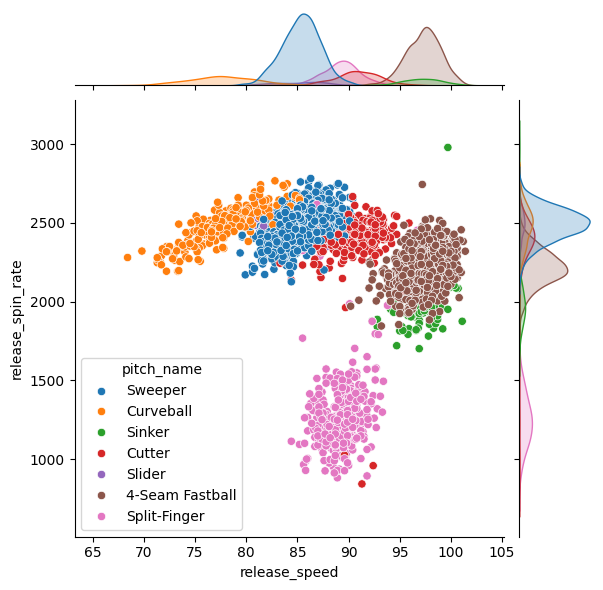

In [70]:
# visualizations
sns.jointplot(pitches_train, x="release_speed" , y="release_spin_rate" , hue="pitch_name")

As shown above, the jointplot reflects the relationship between two variables release_speed and release_spin_rate while coloring the data points based on the categorical and response variable, pitch_name. This plot provides possible insight into how velocity of the pitch is related to the spin rate of the pitch. This generally shows that slow pitches like curveball tend to have more spin compared to fast pitches like 4-seam fastball.

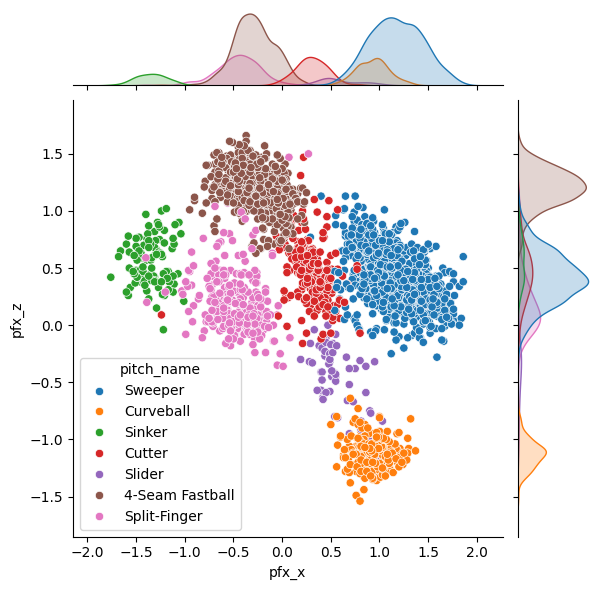

In [71]:
sns.jointplot(pitches_train, x="pfx_x" , y="pfx_z" , hue="pitch_name")

This plot using horizontal and vertical movements highlights how different pitches moves in the air. As shown above, different pitches tend to show distinct movements.

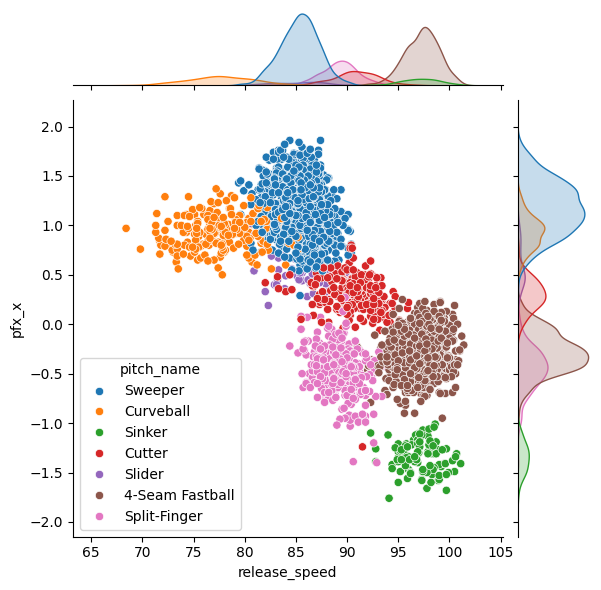

In [72]:
sns.jointplot(pitches_train, x="release_speed" , y="pfx_x" , hue="pitch_name")

This jointplot between velocity and horizontal movement of the different pitch types shows potential relationships between how fast the pitch is and how much the pitch moves horizontally. For instance, from the plot, it seems like faster pitch like 4-Seam Fastball or Sinker tend to end up on the mid to lower portion of the catcher's perspective.

### Models

In [73]:
# process data for ML
# create X and y for train
X_train = pitches_train.drop("pitch_name", axis=1)
y_train = pitches_train["pitch_name"]

# create X and y for test
X_test = pitches_test.drop("pitch_name", axis=1)
y_test = pitches_test["pitch_name"]

In [74]:
# train models
# note numeric and categorical features
numeric_features = ['release_speed', 'release_spin_rate', 'pfx_x', 'pfx_z'] 
categorical_features = ['stand']

# define preprocessing for numeric features
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)

# define preprocessing for categorical features
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# create pipeline, preprocess then classify
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", KNeighborsClassifier()),
    ]
)

In [75]:
# define parameter grid
param_grid = {
    "preprocessor__cat__onehot__drop": [None, "first"],
    "classifier__n_neighbors": [3, 5, 7, 9, 11],
    "classifier__metric": ["euclidean", "manhattan"],
}

In [76]:
# setup grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="accuracy")

In [77]:
# run grid search with cross-validation
mod = grid_search.fit(X_train, y_train)

In [78]:
# inspect (first 10) estimated conditional probabilities in test data
mod.predict_proba(X_test)[:10]

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1.]])

## Results

In [79]:
# report model metrics
accuracy_score(mod.predict(X_test), y_test)

0.9358024691358025

This classification model achieved an accuracy score of 93.58%.

## Discussion

Through training and evaluating the K-nearest Neighbors Classifier, I achieved an accuracy score of 93.58% on the test data. With this high test accuracy, I would definetely consider using this model in a real-world scenario for automatically outputting the pitch type during live broadcasts of Shohei Ohtani's games. The high accurracy score indicates the model can clearly distinguish between distinct pitch types with reasonable precision. So, it is safe to say the model is promising in real-world practice. Additionally, the preprocessing procedures guarantees that both numerical and categorical variables are handled correctly,and the features used for modeling are very relevant to pitch categorization. And, the pipeline-based model implementation makes it simple to integrate into current real-time data processing and prediction systems, guaranteeing a smooth transition from pitch data to classification.

However, the main problem of the model is that it is specifically developed for predicting Shohei Ohtani's pitch types. So, it is not very ideal to apply or utilize this model for other pithers in the MLB. So, each pitcher in the MLB would require their own seperate model trained on their unique pitching data. Since every pitcher in the league has to throw their first MLB pitch someday, we can create a model for any pitcher in the league once we have the sufficient and appropriate data available in our hands. This implies that as more pitchers join the league, new models will be created on a regular basis, improving the classification scheme. Another potential issue for this model is that it utilizes pitching training dataset from 2022 season and a portion of 2023 season for the testing dataset. Although this approach may seem reasonable, many external factors could play a role here. For instance, during the off-season, pitchers can fix or refine their pitching techniques, develop new pitch types, or even change up their pitching patterns due to some reasons. Even though this model may be accurate with the historcial data we have (which is 2022 and a portion of 2023 season), the performance of the model may drastically change when the pitchers goes through their change. In order to maintain accuracy of the model, continuous monitoring and modifying of the model with new data is crucial. Another potential source of problem of the model would arise from the use of KNN classifier. Since KNN classifer relies on distance metrics and calculations of train samples, it can be an intensive process computationally. Even though KNN can make predictions in real time, the speed can change depending on how many pitches are analyzed and how the model's parameters are set. For this specific scenario, other algorithms or methods that are faster, such as decision trees, would be more practical and appropriate for reducing computing or calculating time while maintaining accuracy.

### Conclusion

Overall, I would only use this classification model for predicting the pitch type thrown specficially by Shohei Ohtani, but no other pitchers.
Although the model does show high accuracy and a potential for practical use, constant monitoring and adjustments will be needed to reflect variations in pitching techniques and guarantee instantaneous effectiveness.